# Acquisition via Jupyter Notebook
- ## Given a game_id, player_id and team_id => 
    ## get back df with a single player's 3pt shot info for a single game

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Acquire a dataframe with every shot taken in the 2021-2022 regular season.

Note: This will acquire and cache .csv in notebook directory

In [2]:
filename = 'all_last_season_shots.csv'
if os.path.isfile(filename):
    df_all_shots =  pd.read_csv(filename, index_col=0)
else:
    df = pd.DataFrame()
    index = 0
    for player in players_list:
        print(f'\rFetching index {index} of 714', end='')
        df_pl = shotchartdetail.ShotChartDetail(team_id = player[0],
                                                        player_id = player[1],
                                                        season_type_all_star='Regular Season',
                                                        season_nullable='2021-22',
                                                        context_measure_simple = 'FG3A').get_data_frames()
        time.sleep(.5)
        index += 1
        df = pd.concat([df, df_pl[0]])
        df.to_csv(filename)

### Add 3pt cluster into shot dataframe (only for 3pt shots)

We first remove outliers - set up a df with only 3-pointers to find the iqr and use that to determine distance outliers

In [3]:
df_all_shots = df_all_shots.reset_index(drop = True)

In [4]:
df_all_3pt = df_all_shots[df_all_shots.SHOT_TYPE == '3PT Field Goal']

In [5]:
low = df_all_3pt.SHOT_DISTANCE.quantile(.25)
high = df_all_3pt.SHOT_DISTANCE.quantile(.75)
add = (high-low) * 1.5
bound = high + add
bound

29.0

In [6]:
df_outlier_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE > 29.0]

In [7]:
df_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE <= 29.0]

In [8]:
df_shots = df_all_shots[df_all_shots.SHOT_DISTANCE <= 29.0]

#### Now make them clusters

In [9]:
X = df_3pt[['LOC_X','LOC_Y']]

In [10]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

clusters = kmeans.predict(X)

In [11]:
df_3pt['3pt_location'] = clusters

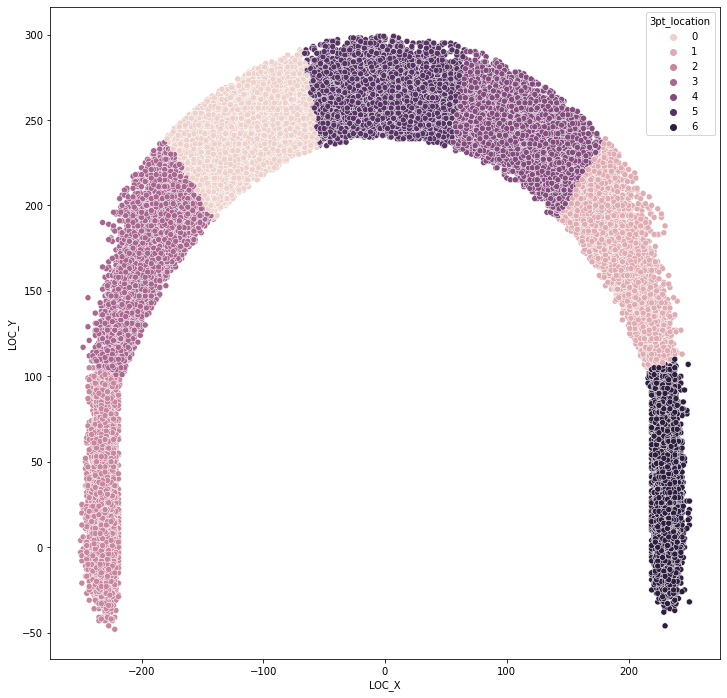

In [12]:
plt.figure(figsize = (12,12))
sns.scatterplot(data =df_3pt, x='LOC_X', y = 'LOC_Y', hue = '3pt_location')
plt.show()

Change location cluster names to descriptives

In [13]:
df_3pt['location'] = df_3pt['3pt_location'].map({0: 'R Above Break', 1: 'L Above Break',2:'L Below Break/Corner',3:'R Center',4:'R Below Break/Corner',5:'Center',6:'L Center'})

In [14]:
location_column = df_3pt[['3pt_location']]

Merge to apply clusters to 3pt shots (all 2pt shots will be NaN)

In [15]:
df_shots = df_shots.merge(location_column, how = 'left', left_index = True, right_index = True)

In [16]:
df_shots

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,3pt_location
0,Shot Chart Detail,22100014,42,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,8,14,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,64,1,1,20211021,ATL,DAL,6.0
1,Shot Chart Detail,22100014,47,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,7,47,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,91,232,1,1,20211021,ATL,DAL,4.0
2,Shot Chart Detail,22100014,305,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,2,1,44,Missed Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,6,79,1,0,20211021,ATL,DAL,NaN
3,Shot Chart Detail,22100014,362,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,9,40,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,69,1,1,20211021,ATL,DAL,6.0
4,Shot Chart Detail,22100014,433,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,4,24,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,134,210,1,0,20211021,ATL,DAL,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216717,Shot Chart Detail,22100382,22,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,10,50,Made Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,2,11,1,1,20211210,CHA,SAC,NaN
216718,Shot Chart Detail,22100382,36,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,9,8,Missed Shot,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,9,23,1,0,20211210,CHA,SAC,NaN
216719,Shot Chart Detail,22100382,40,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,8,53,Made Shot,Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,5,17,1,1,20211210,CHA,SAC,NaN
216720,Shot Chart Detail,22100382,48,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,8,11,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,19,38,193,1,0,20211210,CHA,SAC,NaN


### Create a test Case:

In [17]:
team_id = teams.find_team_by_abbreviation('SAS')['id'] # For SA Spurs

player_id = players.find_players_by_full_name("Keldon Johnson")[0]['id'] # For Keldon Johnson

game_id = '0022100010' # First game of year Spurs vs. Magic - note that game id must be converted to an int in df_shots

### Start with the base of the analysis dataframe(s) - win probability

In [18]:
# Select for a single game
df_base = winprobabilitypbp.WinProbabilityPBP(game_id).get_data_frames()[0]

Create linking column, 'absolute time' - game seconds since play started

In [19]:
# Utilize user function to create absolute time (in seconds) column
df_base['abs_time'] = np.where(df_base.PERIOD <5,
                     ((df_base.PERIOD - 1) * 720 + (720 - df_base.SECONDS_REMAINING)),
                     (2880 + (df_base.PERIOD - 5) * 300 + (300 - df_base.SECONDS_REMAINING)))

### Rotation Dataframe (need this to get player minutes and minutes since rest)

In [20]:
df_rotation = gamerotation.GameRotation(game_id).get_data_frames()

'Game Rotation' returns all the minutes (play time in the court) for every player in the game, seperated into Home and Visitor Dataframes.  As such we search through players for the records with our player_id.  Returns a dataframe holding their rotational stats, most importantly in_time and out_time.

In [21]:
for i in range(2):
    for player in df_rotation[i].PERSON_ID:
        if player == player_id:
            df_player_roto = df_rotation[i][df_rotation[i].PERSON_ID == player]

We need to convert the rotational time in 1/10ths of second, into seconds, then isolate those times out.

In [22]:
df_player_roto['abs_in_time'] = df_player_roto.IN_TIME_REAL/10
df_player_roto['abs_out_time'] = df_player_roto.OUT_TIME_REAL/10
df_player_roto_times = df_player_roto[['abs_in_time','abs_out_time']].reset_index(drop = 'True')

Create a list of zipped in_time and out_time (which bound active time on the court).

In [23]:
zipped = list(zip(df_player_roto_times.abs_in_time, df_player_roto_times.abs_out_time))

In [24]:
zipped

[(0.0, 501.0), (856.0, 1322.0), (1440.0, 1817.0), (2271.0, 2586.0)]

Now filter out the times of the game (from df_base) that align with the player's play time.

In [25]:
# Let me create a holder dataframe as I pull slices off from the base
df_player_game = pd.DataFrame()
for tuplez in zipped:
    df_slice = df_base[(df_base.abs_time >= tuplez[0]) & (df_base.abs_time <= tuplez[1])]
    df_player_game = pd.concat([df_player_game, df_slice])
df_player_game

,GAME_ID,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD,SECONDS_REMAINING,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time
0,0022100010,2.0,0.58808,0.41192,0,0,0,1,720.0,NaN,None,Start of 1st Period (8:43 PM EST),,12:00,1.0,0.0
1,0022100010,4.0,0.61352,0.38648,0,0,0,1,720.0,1.0,None,Jump Ball Poeltl vs. Bamba: Tip to Johnson,h,12:00,1.0,0.0
2,0022100010,NaN,0.61350,0.38650,0,0,0,1,719.0,1.0,None,None,None,None,NaN,1.0
3,0022100010,NaN,0.61348,0.38652,0,0,0,1,718.0,1.0,None,None,None,None,NaN,2.0
4,0022100010,NaN,0.61346,0.38654,0,0,0,1,717.0,1.0,None,None,None,None,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749,0022100010,632.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SPURS Rebound,h,4:54,1.0,2586.0
2750,0022100010,633.0,NaN,NaN,109,84,25,4,294.0,1.0,None,Out-of-Bounds,,4:54,0.0,2586.0
2751,0022100010,634.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SUB: Bates-Diop FOR Johnson,h,4:54,1.0,2586.0
2752,0022100010,635.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SUB: Primo FOR White,h,4:54,1.0,2586.0


In [28]:
df_test = df_player_game.copy()

In [29]:
# Need to create a way to track total playing time (we'll capture in seconds, even though NBA stat is 'minutes')
# df_test['in_game_seconds'] =

In [30]:
# Need to create a way to track time since last break (we'll capture in seconds, even though NBA stat is 'minutes')
# df_test['seconds_since_rest'] = 

### To Do:
- Need to create columns with total time played and current time played.
- *Might* need to find and eliminate unecessary rows (i.e. SUBs, etc. - basically mutiple entries for a abs_time

#### Shot Details

In [31]:
df_shots['abs_time'] = np.where(df_shots.PERIOD < 5,
                                (df_shots.PERIOD - 1) * 720 + (720 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)),
                                2880 + ((df_shots.PERIOD - 5) * 300) + (300 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)))

In [32]:
df_game_shots = df_shots[df_shots.GAME_ID == int(game_id)]

In [33]:
df_game_shots = df_game_shots[df_game_shots.PLAYER_ID == player_id]

In [34]:
df_game_shots.reset_index(drop = True)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,3pt_location,abs_time
0,Shot Chart Detail,22100010,20,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,10,27,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,16,-134,97,1,1,20211020,SAS,ORL,NaN,93
1,Shot Chart Detail,22100010,70,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,6,52,Made Shot,Reverse Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,-4,1,1,20211020,SAS,ORL,NaN,308
2,Shot Chart Detail,22100010,81,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,5,56,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-20,6,1,0,20211020,SAS,ORL,NaN,364
3,Shot Chart Detail,22100010,212,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,9,11,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-23,7,1,0,20211020,SAS,ORL,NaN,889
4,Shot Chart Detail,22100010,234,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,8,29,Missed Shot,Driving Hook Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,-44,59,1,0,20211020,SAS,ORL,NaN,931
5,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,1067
6,Shot Chart Detail,22100010,267,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,2,1,0,20211020,SAS,ORL,NaN,1067
7,Shot Chart Detail,22100010,330,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,2,48,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,2,65,1,1,20211020,SAS,ORL,NaN,1272
8,Shot Chart Detail,22100010,337,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,2,16,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,15,-157,17,1,1,20211020,SAS,ORL,NaN,1304
9,Shot Chart Detail,22100010,414,1629640,Keldon Johnson,1610612759,San Antonio Spurs,3,9,45,Made Shot,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,23,6,1,1,20211020,SAS,ORL,NaN,1575


In [35]:
teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation']

'SAS'

In [36]:
df_game_shots['player_h_v'] = np.where(teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation'] == df_game_shots.HTM, 'Home', 'Visitor')

# Using current game df without seconds played and seconds since break

In [37]:
df_almostthere = df_player_game.merge(df_game_shots, how = 'inner', on = 'abs_time')

In [38]:
df_almostthere

,GAME_ID_x,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD_x,SECONDS_REMAINING_x,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time,GRID_TYPE,GAME_ID_y,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD_y,MINUTES_REMAINING,SECONDS_REMAINING_y,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,3pt_location,player_h_v
0,0022100010,20.0,0.55487,0.44513,5,7,-2,1,627.0,0.0,None,Johnson 17' Pullup Jump Shot (3 PTS),h,10:27,1.0,93.0,Shot Chart Detail,22100010,20,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,10,27,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,16,-134,97,1,1,20211020,SAS,ORL,NaN,Home
1,0022100010,70.0,0.50397,0.49603,13,17,-4,1,412.0,0.0,None,Johnson Reverse Dunk (6 PTS) (White 1 AST),h,6:52,1.0,308.0,Shot Chart Detail,22100010,70,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,6,52,Made Shot,Reverse Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,-4,1,1,20211020,SAS,ORL,NaN,Home
2,0022100010,81.0,0.52545,0.47455,13,17,-4,1,356.0,1.0,None,MISS Johnson 2' Driving Layup,h,5:56,1.0,364.0,Shot Chart Detail,22100010,81,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,5,56,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-20,6,1,0,20211020,SAS,ORL,NaN,Home
3,0022100010,212.0,0.67537,0.32463,39,36,3,2,551.0,1.0,None,MISS Johnson 2' Layup#@#Bamba BLOCK (2 BLK),h,9:11,1.0,889.0,Shot Chart Detail,22100010,212,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,9,11,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-23,7,1,0,20211020,SAS,ORL,NaN,Home
4,0022100010,234.0,0.67639,0.32361,39,36,3,2,509.0,1.0,None,MISS Johnson 7' Driving Hook Shot,h,8:29,1.0,931.0,Shot Chart Detail,22100010,234,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,8,29,Missed Shot,Driving Hook Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,-44,59,1,0,20211020,SAS,ORL,NaN,Home
5,0022100010,267.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,MISS Johnson 1' Layup,h,6:13,1.0,1067.0,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,Home
6,0022100010,267.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,MISS Johnson 1' Layup,h,6:13,1.0,1067.0,Shot Chart Detail,22100010,267,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,2,1,0,20211020,SAS,ORL,NaN,Home
7,0022100010,268.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,Johnson REBOUND (Off:2 Def:1),h,6:13,1.0,1067.0,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,Home
8,0022100010,268.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,Johnson REBOUND (Off:2 Def:1),h,6:13,1.0,1067.0,Shot Chart Detail,22100010,267,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,2,1,0,20211020,SAS,ORL,NaN,Home
9,0022100010,269.0,0.76172,0.23828,45,38,7,2,373.0,0.0,None,Johnson Tip Layup Shot (8 PTS),h,6:13,1.0,1067.0,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,Home


In [39]:
df_almostthere['score_margin'] = np.where(df_almostthere.player_h_v == 'Home', df_almostthere.HOME_SCORE_MARGIN, df_almostthere.HOME_SCORE_MARGIN * -1)

In [40]:
if df_almostthere.loc[0,'player_h_v'] == 'Home':
    df_almostthere = df_almostthere.drop(columns = ['VISITOR_PCT'])
    df_almostthere = df_almostthere.rename(columns = {'HOME_PCT':"WIN_PCT"})
else:
    df_almostthere = df_almostthere.drop(columns = ['HOME_PCT'])
    df_almostthere = df_almostthere.rename(columns = {'VISITOR_PCT':"WIN_PCT"})

In [41]:
df_almostthere['play_points'] = np.where(df_almostthere.SHOT_TYPE == '2PT Field Goal',
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 2,0),
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 3,0))

In [42]:
df_almostthere['points'] = df_almostthere['play_points'].cumsum()

In [43]:
df_almostthere['shots_taken'] = df_almostthere['SHOT_ATTEMPTED_FLAG'].cumsum()
df_almostthere['shots_hit'] = df_almostthere['SHOT_MADE_FLAG'].cumsum()
df_almostthere['game_pct'] = round(df_almostthere['shots_hit']/df_almostthere['shots_taken'],2)

In [44]:
df_almostthere.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GAME_ID_x            17 non-null     object 
 1   EVENT_NUM            17 non-null     float64
 2   WIN_PCT              17 non-null     float64
 3   HOME_PTS             17 non-null     int64  
 4   VISITOR_PTS          17 non-null     int64  
 5   HOME_SCORE_MARGIN    17 non-null     int64  
 6   PERIOD_x             17 non-null     int64  
 7   SECONDS_REMAINING_x  17 non-null     float64
 8   HOME_POSS_IND        17 non-null     float64
 9   HOME_G               0 non-null      object 
 10  DESCRIPTION          17 non-null     object 
 11  LOCATION             17 non-null     object 
 12  PCTIMESTRING         17 non-null     object 
 13  ISVISIBLE            17 non-null     float64
 14  abs_time             17 non-null     float64
 15  GRID_TYPE            17 non-null     objec

In [45]:
columns_to_drop = [
    'GAME_ID_x',
    'EVENT_NUM',
    'HOME_PTS',
    'VISITOR_PTS',
    'HOME_SCORE_MARGIN',
    'PERIOD_x',
    'SECONDS_REMAINING_x',
    'HOME_POSS_IND',
    'HOME_G',
    'LOCATION',
    'PCTIMESTRING',
    'ISVISIBLE',
    'GRID_TYPE',
    'GAME_EVENT_ID',
    'MINUTES_REMAINING',
    'SECONDS_REMAINING_y',
    'EVENT_TYPE',
    'SHOT_ZONE_BASIC',
    'SHOT_ZONE_AREA',
    'SHOT_ZONE_RANGE',
    'LOC_X',
    'LOC_Y',
    'SHOT_ATTEMPTED_FLAG',
    'SHOT_MADE_FLAG',
    'GAME_DATE',
    'HTM',
    'VTM']

In [46]:
df_almostthere = df_almostthere.drop(columns = columns_to_drop)

In [47]:
df_almostthere.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WIN_PCT        17 non-null     float64
 1   DESCRIPTION    17 non-null     object 
 2   abs_time       17 non-null     float64
 3   GAME_ID_y      17 non-null     int64  
 4   PLAYER_ID      17 non-null     int64  
 5   PLAYER_NAME    17 non-null     object 
 6   TEAM_ID        17 non-null     int64  
 7   TEAM_NAME      17 non-null     object 
 8   PERIOD_y       17 non-null     int64  
 9   ACTION_TYPE    17 non-null     object 
 10  SHOT_TYPE      17 non-null     object 
 11  SHOT_DISTANCE  17 non-null     int64  
 12  3pt_location   1 non-null      float64
 13  player_h_v     17 non-null     object 
 14  score_margin   17 non-null     int64  
 15  play_points    17 non-null     int64  
 16  points         17 non-null     int64  
 17  shots_taken    17 non-null     int64  
 18  shots_hit   

In [48]:
columns_to_rename = {'WIN_PCT':'win_probability',
                     'DESCRIPTION':'play_description',
                     'GAME_ID_y':'game_id',
                     'PLAYER_ID':'player_id',
                     'PLAYER_NAME':'player',
                     'TEAM_ID':'team_id',
                     'TEAM_NAME':'team',
                     'PERIOD_y':'period',
                     'ACTION_TYPE':'shot_type',
                     'SHOT_TYPE':'2pt_or_3pt',
                     'SHOT_DISTANCE':'distance'}

In [49]:
df_almostthere = df_almostthere.rename(columns = columns_to_rename)

In [50]:
df_game_player_target = df_almostthere[df_almostthere['2pt_or_3pt'] == '3PT Field Goal']

### The returned stats for the game:

In [51]:
df_game_player_target

,win_probability,play_description,abs_time,game_id,player_id,player,team_id,team,period,shot_type,2pt_or_3pt,distance,3pt_location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
16,0.87958,MISS Johnson 26' 3PT Jump Shot,1641.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,3,Jump Shot,3PT Field Goal,25,1.0,Home,10,0,18,17,9,0.53


### To do:
- Continue to assess and remove/clean/rename columns!